importing required libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

import hvplot.pandas
import holoviews as hv

# setting bokeh as backend
hv.extension('bokeh')

# going to use show() to open plot in browser
from bokeh.plotting import show

In [3]:
## loading the training and test data from kaggle 

In [4]:
test_df=pd.read_csv('test.csv')
train_df=pd.read_csv('train.csv')

In [5]:
train_df.head()

Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 81 columns]

In [6]:
test_df.head()

Id  MSSubClass MSZoning  ...  YrSold  SaleType SaleCondition
0  1461          20       RH  ...    2010        WD        Normal
1  1462          20       RL  ...    2010        WD        Normal
2  1463          60       RL  ...    2010        WD        Normal
3  1464          60       RL  ...    2010        WD        Normal
4  1465         120       RL  ...    2010        WD        Normal

[5 rows x 80 columns]

In [7]:
#Save the 'Id' column
train_ID = train_df['Id']
test_ID = test_df['Id']

### Exploratory Data Analysis

analyzing the data found in the saleprice column

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


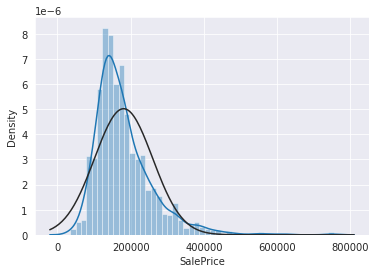

In [8]:
sns.distplot(train_df['SalePrice'] , fit=norm)

since the target variable is skewed to the left we are going to log transform the data to achieve a normal distribution

In [9]:
train_df['SalePrice'] = np.log(train_df['SalePrice'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


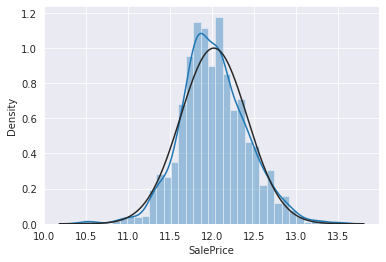

In [10]:
#Check the new distribution to see the normalized data
sns.distplot(train_df['SalePrice'] , fit=norm);

Looking at the relationship between SalePrice and certain features

Relationship between SalePrice and OverallQual

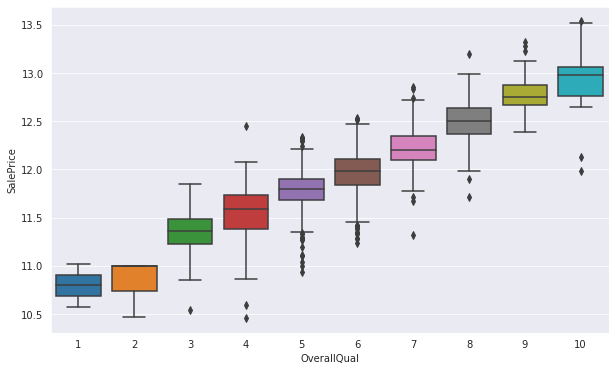

In [11]:
fig = plt.figure(figsize= (10,6))
sns.boxplot(x = "OverallQual", y = "SalePrice", data = train_df)
plt.show()

Relationship between Saleprice and Neigbhourhood

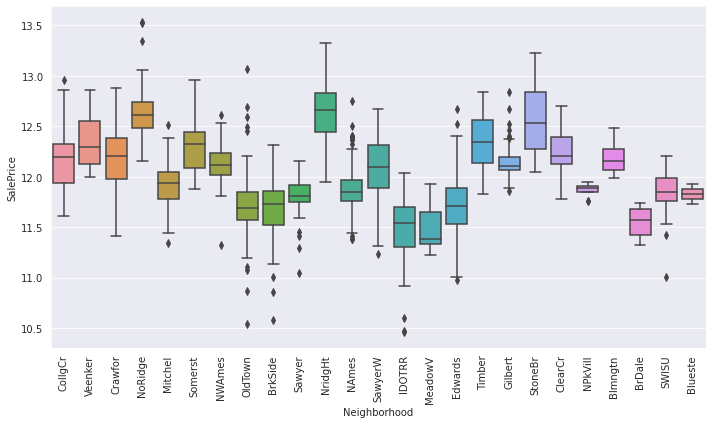

In [12]:
fig = plt.figure(figsize= (10,6))
sns.boxplot(x = "Neighborhood", y = "SalePrice", data = train_df)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Correlation matrix

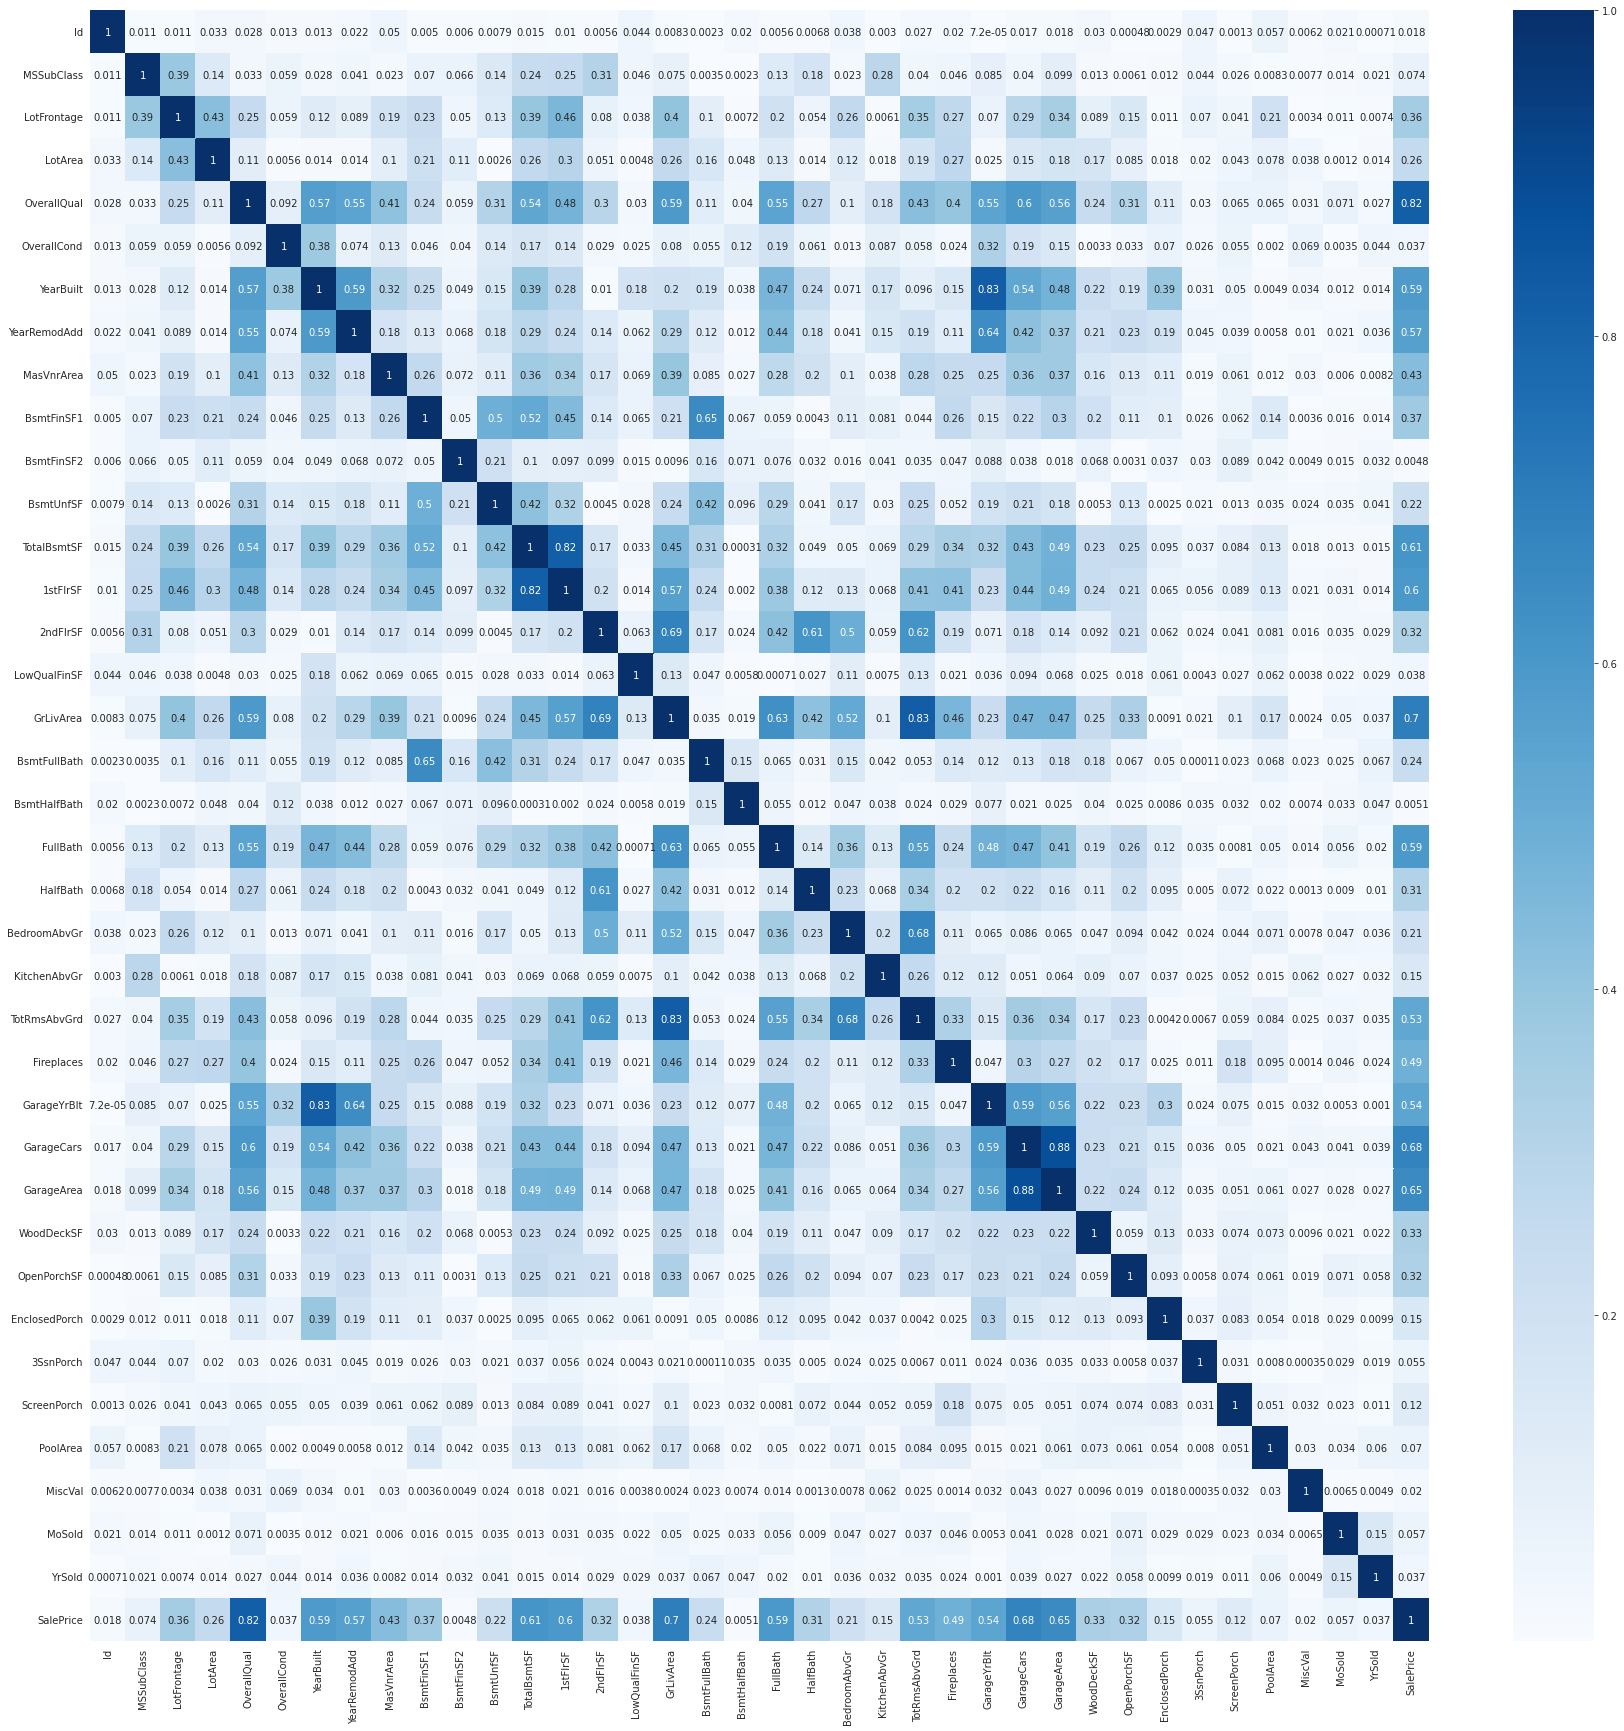

In [73]:
# Create correlation matrix
corr_matrix = train_df.corr().abs()

fig = plt.figure(figsize= (30,30))
sns.heatmap(corr_matrix, annot=True, vmax=1, cmap='Blues', square=False)

### Feature Engineering

joining the test and train data where the saleprice column has been dropped to make it easier to work with for cleaning the data 

In [14]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

y_train = train_df[['Id','SalePrice']]
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 80)


In [15]:
y_train.head()

Id  SalePrice
0   1  12.247694
1   2  12.109011
2   3  12.317167
3   4  11.849398
4   5  12.429216

In [16]:
all_data.head()

Id  MSSubClass MSZoning  LotFrontage  ...  MoSold YrSold SaleType SaleCondition
0   1          60       RL         65.0  ...       2   2008       WD        Normal
1   2          20       RL         80.0  ...       5   2007       WD        Normal
2   3          60       RL         68.0  ...       9   2008       WD        Normal
3   4          70       RL         60.0  ...       2   2006       WD       Abnorml
4   5          60       RL         84.0  ...      12   2008       WD        Normal

[5 rows x 80 columns]

#### Data Cleaning

In [17]:
#assessing all the columns in the data that have missing data 
forever=round(all_data.isnull().mean()*100,2)
forever = forever[forever > 0]

In [18]:
forever

MSZoning         0.14
LotFrontage     16.65
Alley           93.22
Utilities        0.07
Exterior1st      0.03
Exterior2nd      0.03
MasVnrType       0.82
MasVnrArea       0.79
BsmtQual         2.77
BsmtCond         2.81
BsmtExposure     2.81
BsmtFinType1     2.71
BsmtFinSF1       0.03
BsmtFinType2     2.74
BsmtFinSF2       0.03
BsmtUnfSF        0.03
TotalBsmtSF      0.03
Electrical       0.03
BsmtFullBath     0.07
BsmtHalfBath     0.07
KitchenQual      0.03
Functional       0.07
FireplaceQu     48.65
GarageType       5.38
GarageYrBlt      5.45
GarageFinish     5.45
GarageCars       0.03
GarageArea       0.03
GarageQual       5.45
GarageCond       5.45
PoolQC          99.66
Fence           80.44
MiscFeature     96.40
SaleType         0.03
dtype: float64

In [19]:
forever = forever.sort_values(ascending=False)

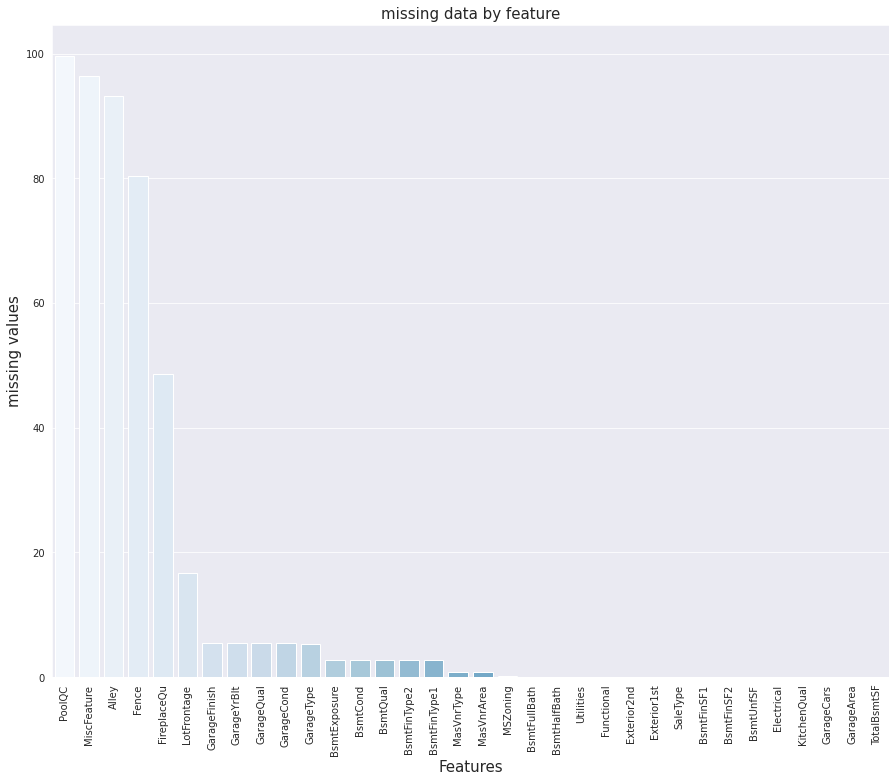

In [78]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=forever.index, y=forever,palette='Blues')
plt.xlabel('Features', fontsize=15)
plt.ylabel('missing values', fontsize=15)
plt.title('missing data by feature', fontsize=15)

plt.savefig('missingdatabyfeatures.jpg')

Handling the missing data for the missing data columns 

In [21]:
#top 5 missing data columns
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["GarageFinish"] = all_data["GarageFinish"].fillna("None")
all_data["GarageQual"] = all_data["GarageQual"].fillna("None")
all_data["GarageCond"] = all_data["GarageCond"].fillna("None")
all_data["GarageType"] = all_data["GarageType"].fillna("None")


In [22]:
for col in ['BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType1','BsmtFinType2']:
    all_data[col] = all_data[col].fillna('None')

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [23]:
# Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


In [24]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [25]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [26]:
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [27]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [28]:
all_data.head()

Id MSSubClass MSZoning  LotFrontage  ...  MoSold YrSold SaleType SaleCondition
0   1         60       RL         65.0  ...       2   2008       WD        Normal
1   2         20       RL         80.0  ...       5   2007       WD        Normal
2   3         60       RL         68.0  ...       9   2008       WD        Normal
3   4         70       RL         60.0  ...       2   2006       WD       Abnorml
4   5         60       RL         84.0  ...      12   2008       WD        Normal

[5 rows x 79 columns]

Fixing Skewed data 

In [29]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_data.columns:
    if all_data[i].dtype in numeric_dtypes:
        numeric.append(i)

[Text(0.5, 1.0, 'Numeric Distribution of Features')]

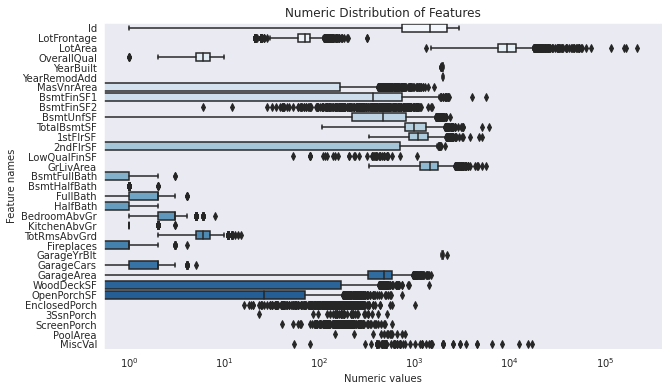

In [77]:
# Create box plots for all numeric features
#sns.set_style("white")
f, ax = plt.subplots(figsize=(10, 6))
ax.set_xscale("log")
ax = sns.boxplot(data=all_data[numeric] , orient="h", palette="Blues")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
#sns.despine(trim=True, left=True)

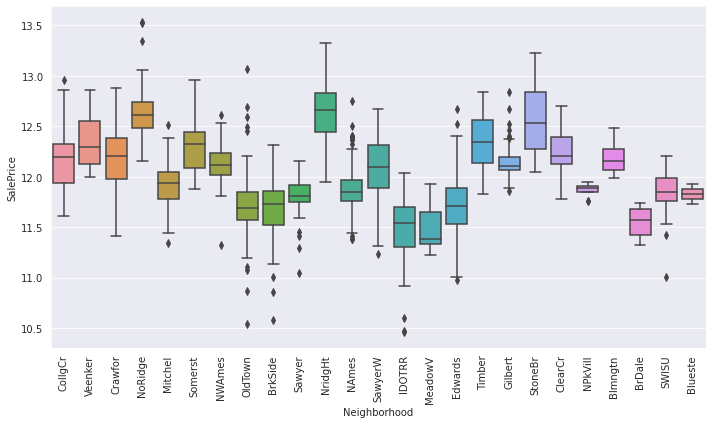

In [31]:
fig = plt.figure(figsize= (10,6))
sns.boxplot(x = "Neighborhood", y = "SalePrice", data = train_df)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Dealing with categorical variables in the data 

In [32]:
## Utilizing dummy variables for the categorical variables
#all_data = pd.get_dummies(all_data).reset_index(drop=True)

decided to use just the numerical variables for the modelling

In [33]:
all_data=all_data._get_numeric_data().reset_index(drop=True)

In [34]:
all_data.head()

Id  LotFrontage  LotArea  ...  ScreenPorch  PoolArea  MiscVal
0   1         65.0     8450  ...            0         0        0
1   2         80.0     9600  ...            0         0        0
2   3         68.0    11250  ...            0         0        0
3   4         60.0     9550  ...            0         0        0
4   5         84.0    14260  ...            0         0        0

[5 rows x 33 columns]

In [35]:
#data without the y variable
train_labels = all_data[:ntrain]
test_labels = all_data[ntrain:]

In [36]:
y=y_train.drop(['Id'], axis=1)

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_labels, y_train, test_size=0.3, random_state=42)

In [38]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, train_labels, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# Modelling

Linear Regression

Preparing data for linear regression

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [40]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

In [41]:
# print the intercept
print(lin_reg.intercept_)

[732.33855186  12.02910885]


In [42]:
ind = range(len(y_test))

In [43]:
y_test = np.array(y_test)

In [70]:

plot = pd.DataFrame({'True Values': y_test[:,0], 'Predicted Values': pred[:, 0]}, index = ind).hvplot.scatter(x='True Values', y='Predicted Values')

In [71]:
show(hv.render(plot))

In [45]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.05727087779442216
MSE: 0.01248958745263602
RMSE: 0.11175682284601697
R2 Square 0.9263786042372837
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.05212462169186765
MSE: 0.011735357679083853
RMSE: 0.10832985589893422
R2 Square 0.9242907733411747
__________________________________


In [46]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

Model       MAE      MSE      RMSE  R2 Square  Cross Validation
0  Linear Regression  0.057271  0.01249  0.111757   0.926379           0.82277

Random Forest Regression

In [47]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.model_selection import cross_validate

In [48]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.6074187717825883
MSE: 0.809509587589925
RMSE: 0.8997275074098408
R2 Square 0.649248127745988
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.22479633750810443
MSE: 0.112573841613547
RMSE: 0.33552025514646205
R2 Square 0.9532755093892161
__________________________________


In [49]:
results_df_2 = pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)


In [50]:
results_df.head()

Model       MAE  ...  R2 Square  Cross Validation
0        Linear Regression  0.057271  ...   0.926379           0.82277
1  Random Forest Regressor  0.607419  ...   0.649248           0.00000

[2 rows x 6 columns]

Artificial Neural Networks

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

seed = 7
np.random.seed(seed)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


model = Sequential()

model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer=Adam(0.00001), loss='mse')

r = model.fit(X_train, y_train,
              validation_data=(X_test,y_test),
              batch_size=1,
              epochs=100)

Epoch 1/100
1022/1022 [==============================] - 4s 3ms/step - loss: 358223.2812 - val_loss: 346908.3750
Epoch 2/100
1022/1022 [==============================] - 3s 2ms/step - loss: 354672.0938 - val_loss: 340059.9062
Epoch 3/100
1022/1022 [==============================] - 3s 3ms/step - loss: 340728.4375 - val_loss: 316940.2500
Epoch 4/100
1022/1022 [==============================] - 3s 3ms/step - loss: 306239.5000 - val_loss: 272884.8438
Epoch 5/100
1022/1022 [==============================] - 2s 2ms/step - loss: 260802.3594 - val_loss: 235739.6875
Epoch 6/100
1022/1022 [==============================] - 3s 3ms/step - loss: 233905.1250 - val_loss: 223524.6719
Epoch 7/100
1022/1022 [==============================] - 3s 3ms/step - loss: 225361.2812 - val_loss: 220440.6250
Epoch 8/100
1022/1022 [==============================] - 2s 2ms/step - loss: 221966.3125 - val_loss: 218193.7344
Epoch 9/100
1022/1022 [==============================] - 2s 2ms/step - loss: 220137.8750 - val_l

In [52]:
pd.DataFrame({'True Values': y_test[:,0], 'Predicted Values': pred[:, 0]}, index = ind).hvplot.scatter(x='True Values', y='Predicted Values')

:Scatter   [True Values]   (Predicted Values)

In [53]:
pd.DataFrame(r.history)

loss       val_loss
0   358223.281250  346908.375000
1   354672.093750  340059.906250
2   340728.437500  316940.250000
3   306239.500000  272884.843750
4   260802.359375  235739.687500
..            ...            ...
95  177486.156250  174797.656250
96  177464.921875  174751.031250
97  177380.421875  174724.281250
98  177365.546875  174683.562500
99  177297.359375  174619.109375

[100 rows x 2 columns]

In [68]:
plot=pd.DataFrame(r.history).hvplot.line(y=['loss', 'val_loss'])

In [69]:
show(hv.render(plot))

In [55]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

In [56]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test[:,0], test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train[:,0], train_pred)

Test set evaluation:
_____________________________________
MAE: 365.2654447381355
MSE: 178976.95431065816
RMSE: 423.0566797849411
R2 Square -0.056958374431014036
__________________________________
Train set evaluation:
_____________________________________
MAE: 368.1454974947144
MSE: 182107.69171253798
RMSE: 426.7407781224311
R2 Square -0.005122334640954573
__________________________________


In [57]:
results_df_3 = pd.DataFrame(data=[["Artficial Neural Network", *evaluate(y_test[:,0], test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_3, ignore_index=True)
results_df

Model         MAE  ...  R2 Square  Cross Validation
0         Linear Regression    0.057271  ...   0.926379           0.82277
1   Random Forest Regressor    0.607419  ...   0.649248           0.00000
2  Artficial Neural Network  365.265445  ...  -0.056958           0.00000

[3 rows x 6 columns]

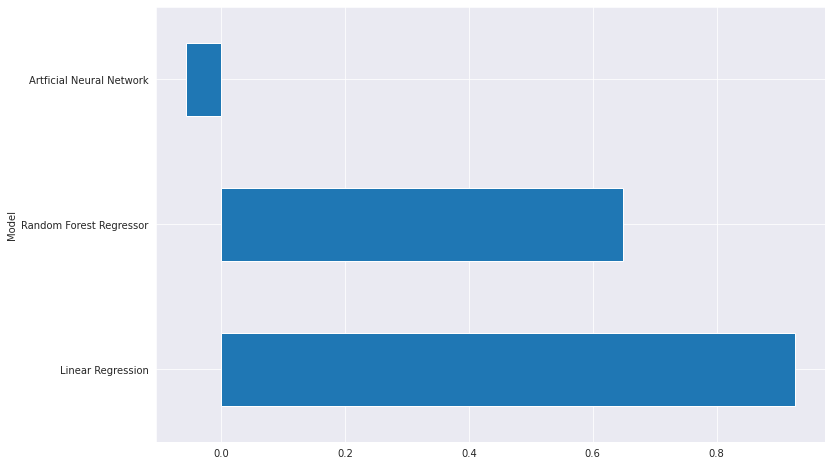

In [58]:
results_df.set_index('Model', inplace=True)
results_df['R2 Square'].plot(kind='barh', figsize=(12, 8))